In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
from tqdm import *


In [2]:
img_list_path = "C:\\Users\\amith\\Documents\\Datasets\\10 - Land Segmentation using U-Net Architecture"

img_list = os.listdir(img_list_path)

terrain_img_list = list(map(lambda x: x if "_t" in x else None,img_list))
while None in terrain_img_list:
    terrain_img_list.remove(None)
terrain_img_list.sort()

height_img_list = list(map(lambda x: x if "_h" in x else None,img_list))
while None in height_img_list:
    height_img_list.remove(None)
height_img_list.sort()

segmented_img_list = list(map(lambda x: x if "_i2" in x else None,img_list))
while None in segmented_img_list:
    segmented_img_list.remove(None)
segmented_img_list.sort()

print(len(terrain_img_list))
print(len(height_img_list))
print(len(segmented_img_list))


5000
5000
5000


In [3]:
cv2.imread(img_list_path + "\\" + terrain_img_list[0]).shape


(512, 512, 3)

In [4]:
print(terrain_img_list[0:5])
print(height_img_list[0:5])
print(segmented_img_list[0:5])


['0001_t.png', '0002_t.png', '0003_t.png', '0004_t.png', '0005_t.png']
['0001_h.png', '0002_h.png', '0003_h.png', '0004_h.png', '0005_h.png']
['0001_i2.png', '0002_i2.png', '0003_i2.png', '0004_i2.png', '0005_i2.png']


In [5]:
X = []
y = []
for i in tqdm(range(len(terrain_img_list))):

    terrain_img = cv2.imread(filename=img_list_path + "\\" + terrain_img_list[i])
    segmented_img = cv2.imread(filename=img_list_path + "\\" + segmented_img_list[i])

    terrain_img_resized = cv2.resize(terrain_img,(64,64))
    segmented_img_resized = cv2.resize(segmented_img,(64,64))

    terrain_img_scaled = terrain_img_resized / 255.0
    segmented_img_scaled = segmented_img_resized / 255.0

    X.append(terrain_img_scaled)
    y.append(segmented_img_scaled)
X = np.array(X)
y = np.array(y)


100%|██████████| 5000/5000 [01:51<00:00, 44.83it/s]


In [6]:
img_indices = np.array(range(len(X)))
np.random.shuffle(img_indices)

val_test_threshold = int(0.8 * len(img_indices))
train_val_threshold = int(0.8 * val_test_threshold)

train_indices = img_indices[:train_val_threshold]
val_indices = img_indices[train_val_threshold:val_test_threshold]
test_indices = img_indices[val_test_threshold:]

X_train = X[train_indices]
X_val = X[val_indices]
X_test = X[test_indices]

y_train = y[train_indices]
y_val = y[val_indices]
y_test = y[test_indices]


In [7]:
X_train[0].shape


(64, 64, 3)

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation="relu",padding="same",input_shape=(64,64,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"), #1

    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu",padding="same"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"), #2

    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu",padding="same"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding="same"), #3

    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation="relu",padding="same"),
    tf.keras.layers.UpSampling2D(size=(2,2)), #4

    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation="relu",padding="same"),
    tf.keras.layers.UpSampling2D(size=(2,2)), #5

    tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation="relu",padding="same"),
    tf.keras.layers.UpSampling2D(size=(2,2)), #6

    tf.keras.layers.Conv2D(filters=3,kernel_size=(3,3),activation="sigmoid",padding="same"), #7
])


In [16]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 3)      │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,035 (328.26 KB)

 Trainable params: 84,035 (328.26 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.mean_absolute_error,metrics=["accuracy"])


In [18]:
model.fit(x=X_train,y=y_train,epochs=100,verbose=1,callbacks=tf.keras.callbacks.EarlyStopping(patience=2),validation_data=(X_val,y_val))


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4836 - loss: 0.1501 - val_accuracy: 0.6850 - val_loss: 0.0852
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6969 - loss: 0.0830 - val_accuracy: 0.6951 - val_loss: 0.0753
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7130 - loss: 0.0749 - val_accuracy: 0.7111 - val_loss: 0.0712
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7360 - loss: 0.0701 - val_accuracy: 0.7508 - val_loss: 0.0671
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7599 - loss: 0.0657 - val_accuracy: 0.7823 - val_loss: 0.0647
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7900 - loss: 0.0637 - val_accuracy: 0.7507 - val_loss: 0.0652
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8081 - loss: 0.0600 - val_accuracy: 0.7553 - val_loss: 0.0605
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8131 - loss: 0.0617 - 

In [19]:
y_pred = model.predict(X_test)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


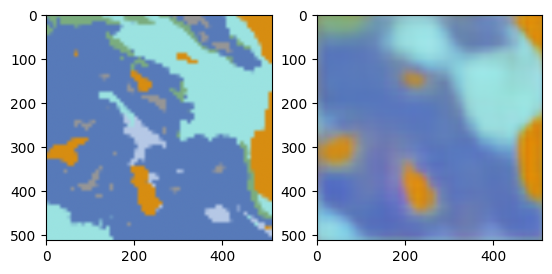

In [20]:
fig,ax = plt.subplots(nrows=1,ncols=2)
ax[0].imshow(cv2.resize(y_test[1],(512,512)))
ax[1].imshow(cv2.resize(y_pred[1],(512,512)))


In [21]:
tf.keras.models.save_model(model=model,filepath="C:\\Users\\amith\\Documents\\GitHub\\udemy\\10 - Land Segmentation using U-Net Architecture\\ML_model\\TerrainMaskGenerator.h5")

tf.keras.models.save_model(model=model,filepath="C:\\Users\\amith\\Documents\\GitHub\\udemy\\10 - Land Segmentation using U-Net Architecture\\app\\TerrainMaskGenerator.h5")
